# **【回帰】1ガロンあたり何マイル走るかの燃費を予測する**

#1.準備作業

※0章のコマンドはLinuxコマンドであることを留意すること

##ドライブのマウント

■ドライブをマウントする

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


□結果：「Mounted at /content/drive」と表示されること

---



##ディレクトリの作成

■ディレクトリが存在しないことを確認する

In [ ]:
ls -la /content | grep data

drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data/


□結果：「data」ディレクトリが存在しないこと

■ディレクトリを作成する

In [ ]:
mkdir /content/data

□結果：エラーが発生しないこと

■ディレクトリが作成されたことを確認する

In [ ]:
ls -la /content | grep data

drwxr-xr-x 2 root root 4096 Mar 16 03:37 data/
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data/


□結果：「data」ディレクトリが存在すること

##カレントディレクトの移動

■カレントディレクトリを移動する

In [ ]:
cd /content/data

/content/data


□結果：「/content/data」と表示されること

##データの格納

■/content/dataディレクトリにauto_mpg.csvを手動で格納する

※ファイル名が「auto_mgp.csv」であるが、正しくは「auto_mpg.csv」である。  
ファイル名が「auto_mpg.csv」である前提(適宜リネーム等)で進める

□結果：エラーが発生しないこと

■格納したファイルが存在することを確認する

In [ ]:
ls -la | grep auto_mpg.csv

-rw-r--r-- 1 root root 12795 Mar 16 03:37 auto_mpg.csv


□結果：「auto_mpg.csv」が存在すること

#2.前処理とチューニング

###2.1.CSVファイルの読み込み

In [ ]:
#pandasをインポート
import pandas as pd

#auto_mpg.csvのデータを読み込む(1列目は不要のため読み込まない)
df = pd.read_csv('auto_mpg.csv', index_col = 0)

#データの内容を確認
df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


##2.2.欠損値処理

※[2.2.1. / 2.2.2. / 2.2.3.]のいずれかを実施する

###2.2.1.欠損値の削除

In [ ]:
#欠損値の数を確認する
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
#欠損値を含む行を表示
print(df[df.isnull().any(axis = 1)])

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
32   25.0          4          98.0         NaN    2046          19.0   
126  21.0          6         200.0         NaN    2875          17.0   
330  40.9          4          85.0         NaN    1835          17.3   
336  23.6          4         140.0         NaN    2905          14.3   
354  34.5          4         100.0         NaN    2320          15.8   
374  23.0          4         151.0         NaN    3035          20.5   

     Model Year  Origin  
32           71       1  
126          74       1  
330          80       2  
336          80       1  
354          81       2  
374          82       1  


In [ ]:
#欠損値の削除
non_df = df.dropna() #nonはNo NaNの略

#欠損値の数を確認する
non_df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
#欠損値削除後のデータの内容を確認
non_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


###2.2.2.欠損値の穴埋め

重回帰モデルを用いて、欠損値(Horsepower)を予測する
予測結果で穴埋めを実施する

In [ ]:
#LinearRegressionをインポート
from sklearn.linear_model import LinearRegression

#特徴量を抽出
x = non_df[['MPG', 'Cylinders', 'Displacement', 'Weight', 'Acceleration', 'Model Year', 'Origin']]

#正解データを抽出
t = non_df['Horsepower']

#重回帰モデルのインスタンス生成
model = LinearRegression()
model.fit(x, t)

#欠損値の本来の値を予測させる
#欠損値の有無を抜き出し
condition = df['Horsepower'].isnull()

#欠損行の入力に利用する特徴量だけを抜き出して、モデルで予測
x = df.loc[condition][['MPG', 'Cylinders', 'Displacement', 'Weight', 'Acceleration', 'Model Year', 'Origin']]

#欠損値の予測結果
pred = model.predict(x)

#予測した欠損値の表示
pred

array([58.97484708, 94.07504269, 56.24876075, 98.40964747, 75.65225799,
       74.74148847])

In [ ]:
#欠損値の有無の表示
condition

0      False
1      False
2      False
3      False
4      False
       ...  
393    False
394    False
395    False
396    False
397    False
Name: Horsepower, Length: 398, dtype: bool

In [ ]:
#欠損値ありデータをコピー
non_df = df.copy()

#欠損値を穴埋め
#欠損値がある行のHorsepowerをpredに置換
non_df.loc[condition, 'Horsepower'] = pred

#結果の表示
non_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [ ]:
#欠損値の数を確認する
non_df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

###2.2.3.関数による欠損値補完

In [ ]:
#欠損値の数を確認する
df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
#欠損値を補完
non_df = df.fillna(df.mean())

In [ ]:
#欠損値の数を確認する
non_df.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

##2.3.外れ値処理

※[2.3.1. / 2.3.2.]のいずれかを実施する

###2.3.1.目視による手動処理

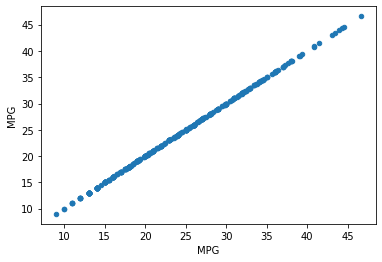

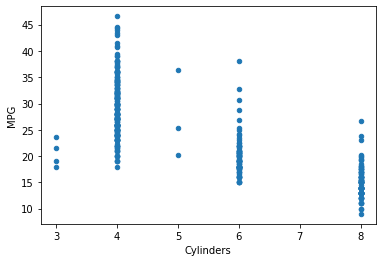

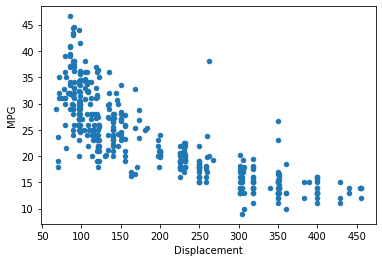

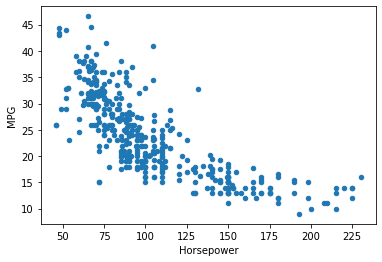

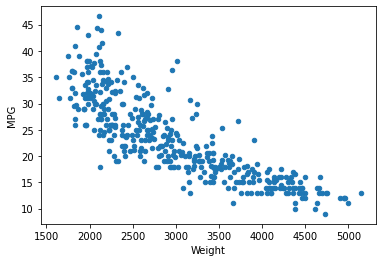

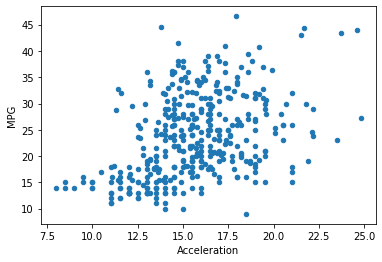

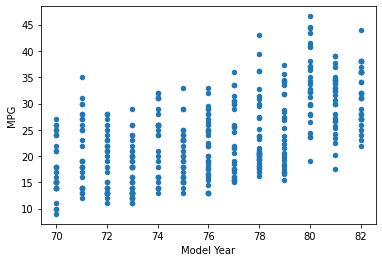

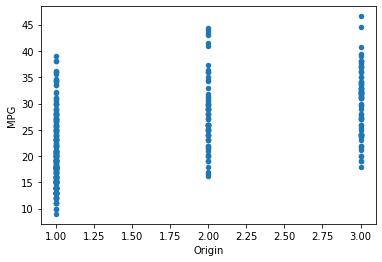

In [ ]:
#グラフの一括表示
for name in non_df.columns:
      non_df.plot(kind = 'scatter', x = name, y = 'MPG')

In [ ]:
#外れ値データの確認
print(non_df[(non_df['MPG'] > 35) & (non_df['Displacement'] > 240)])
print(non_df[(non_df['MPG'] > 30) & (non_df['Horsepower'] > 125)])

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
387  38.0          6         262.0        85.0    3015          17.0   

     Model Year  Origin  
387          82       1  
      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
333  32.7          6         168.0       132.0    2910          11.4   

     Model Year  Origin  
333          80       3  


In [ ]:
#外れ値の削除
non_noo_df = non_df.drop(df.index[[333, 387]]) #nooはNo Outliersの略 

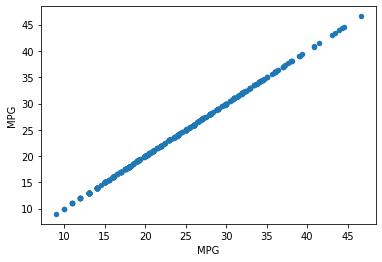

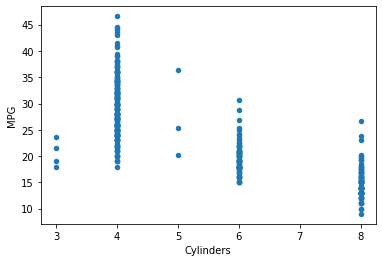

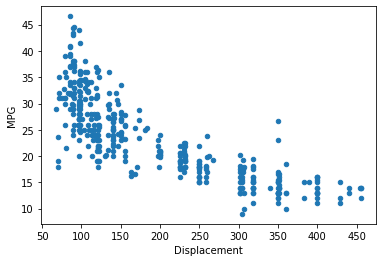

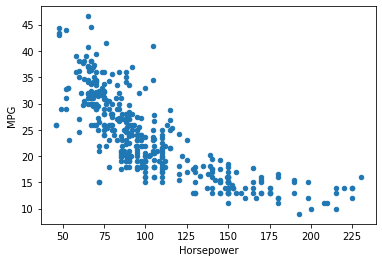

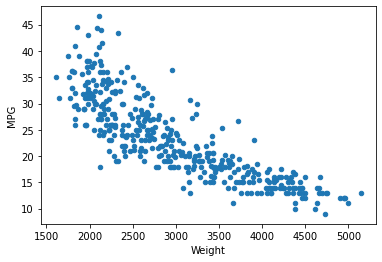

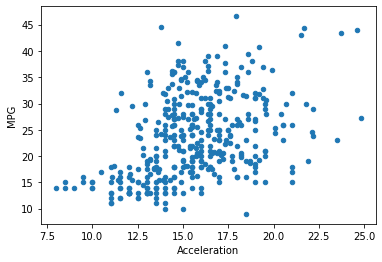

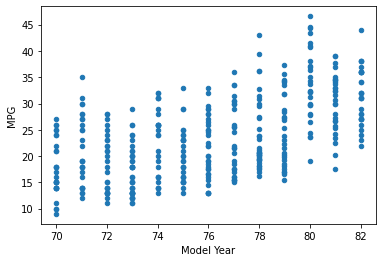

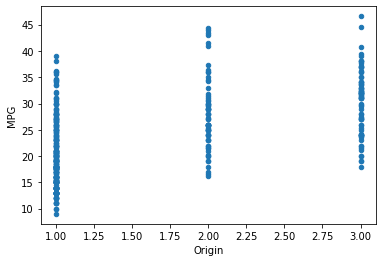

In [ ]:
#外れ値削除後のグラフの一括表示
for name in non_noo_df.columns:
      non_noo_df.plot(kind = 'scatter', x = name, y = 'MPG')

###2.3.2.マハラノビス距離による処理

※データ数が少ないので、デフォルト通り20～30件も削除してよいのか？  
なんとか良い感じに削れないか試行錯誤

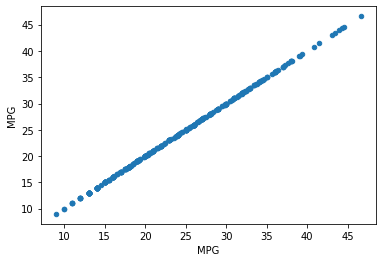

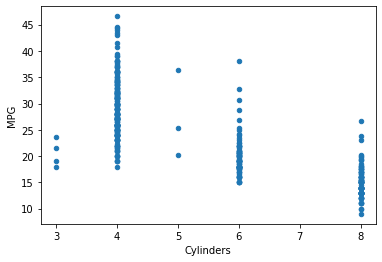

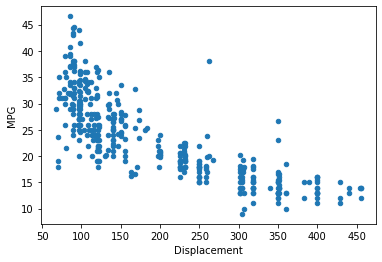

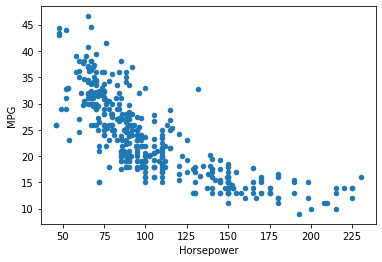

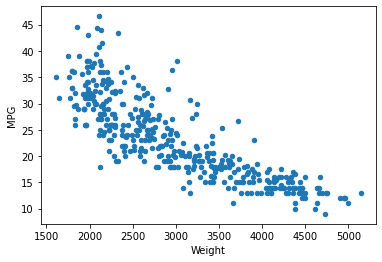

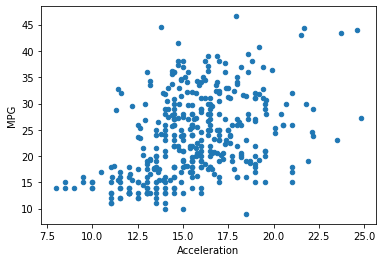

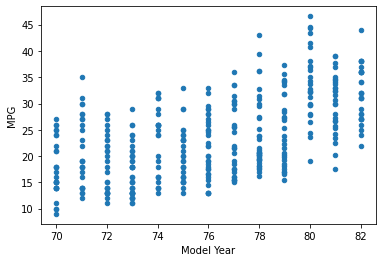

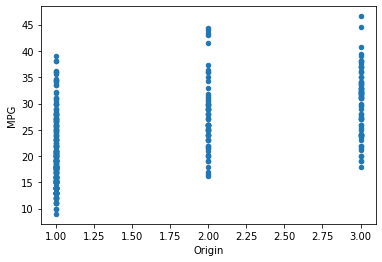

In [ ]:
#グラフの一括表示
for name in non_df.columns:
      non_df.plot(kind = 'scatter', x = name, y = 'MPG')

In [ ]:
#MinCovDet（最小共分散決定量）をインポート
from sklearn.covariance import MinCovDet

#Displacementに対しての外れ値処理
df_tmp_disp = non_df[['MPG', 'Displacement']]
df_tmp_hors = non_df[['MPG', 'Horsepower']]

#最小共分散決定量(Displacement)
mcd = MinCovDet(random_state = 0, support_fraction = 0.95)
mcd.fit(df_tmp_disp)
distance_disp = mcd.mahalanobis(df_tmp_disp)

#最小共分散決定量(Horsepower)
mcd = MinCovDet(random_state = 0, support_fraction = 0.95)
mcd.fit(df_tmp_hors)
distance_hors = mcd.mahalanobis(df_tmp_hors)

In [ ]:
# #MinCovDet（最小共分散決定量）をインポート
# from sklearn.covariance import MinCovDet

# #Displacementに対しての外れ値処理
# # df_tmp = non_df[['MPG', 'Displacement', 'Horsepower']]
# df_tmp = non_df[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']]

# #最小共分散決定量
# mcd = MinCovDet(random_state = 0, support_fraction = 0.7)
# mcd.fit(df_tmp)
# distance = mcd.mahalanobis(df_tmp)

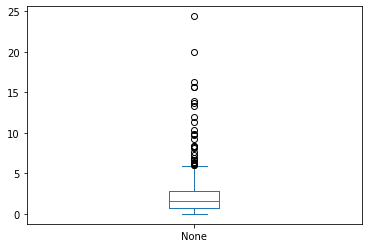

In [ ]:
distance_disp = pd.Series(distance_disp)
distance_disp.plot(kind = "box")

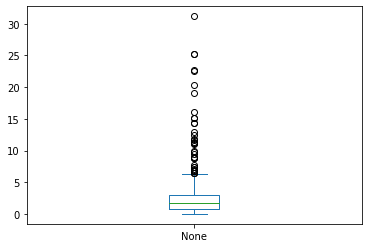

In [ ]:
distance_hors = pd.Series(distance_hors)
distance_hors.plot(kind = "box")

In [ ]:
# distance = pd.Series(distance)
# distance.plot(kind = "box")

In [ ]:
tmp_disp = distance_disp.describe()
tmp_disp

count    392.000000
mean       2.495911
std        2.940561
min        0.004929
25%        0.771031
50%        1.566041
75%        2.868886
max       24.397231
dtype: float64

In [ ]:
tmp_hors = distance_hors.describe()
tmp_hors

count    392.000000
mean       2.810731
std        3.959287
min        0.000371
25%        0.721062
50%        1.683251
75%        2.994808
max       31.180867
dtype: float64

In [ ]:
# tmp = distance.describe()
# tmp

In [ ]:
#iqr算出
iqr_disp = tmp_disp['75%'] - tmp_disp['25%']
print(iqr_disp)

#上限値、下限値
# upper_limit = tmp_disp['75%'] + (1.5 * iqr_disp)
upper_limit = tmp_disp['75%'] + (7.0 * iqr_disp)  #外れ値として2件
print(upper_limit)
# lower_limit = tmp_disp['25%'] - (1.5 * iqr_disp)
lower_limit = tmp_disp['25%'] - (7.0 * iqr_disp)  #外れ値として2件
print(lower_limit)

#外れ値
outliner_disp = distance_disp[ (distance_disp > upper_limit) | (distance_disp < lower_limit)]
outliner_disp

2.097855497134643
17.553874498000315
-13.913957959019328


320    19.992936
381    24.397231
dtype: float64

In [ ]:
#iqr算出
iqr_hors = tmp_hors['75%'] - tmp_hors['25%']
print(iqr_hors)

#上限値、下限値
# upper_limit = tmp_hors['75%'] + (1.5 * iqr_hors)
upper_limit = tmp_hors['75%'] + (10.0 * iqr_hors) #外れ値として1件
print(upper_limit)
# lower_limit = tmp_hors['25%'] - (1.5 * iqr_hors)
lower_limit = tmp_hors['25%'] - (10.0 * iqr_hors) #外れ値として1件
print(lower_limit)

#外れ値
outliner_hors = distance_hors[ (distance_hors > upper_limit) | (distance_hors < lower_limit)]
outliner_hors

2.2737460055476
25.732267735646243
-22.01639838085336


115    31.180867
dtype: float64

In [ ]:
# #iqr算出
# iqr = tmp['75%'] - tmp['25%']
# print(iqr)

# #上限値、下限値
# upper_limit = tmp['75%'] + (8.0 * iqr)  #外れ値：3件：0.8387519287083124
# # upper_limit = tmp['75%'] + (7.0 * iqr)  #外れ値：6件：0.8261625822406395
# # upper_limit = tmp['75%'] + (1.5 * iqr)  #外れ値：41件：0.7746303425502296
# print(upper_limit)
# lower_limit = tmp['25%'] - (8.0 * iqr)  #外れ値：3件：0.8387519287083124
# # lower_limit = tmp['25%'] - (7.0 * iqr)  #外れ値：6件：0.8261625822406395
# # lower_limit = tmp['25%'] - (1.5 * iqr)  #外れ値：41件：0.7746303425502296
# print(lower_limit)

# #外れ値
# outliner = distance[ (distance > upper_limit) | (distance < lower_limit)]
# outliner

In [ ]:
#DisplacementとHorsepowerの外れ値を結合(合計3件)
outliner = pd.concat([outliner_disp, outliner_hors])
outliner = outliner.index.drop_duplicates()
outliner

Int64Index([320, 381, 115], dtype='int64')

In [ ]:
#削除前データ
non_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [ ]:
#外れ値の削除
non_noo_df = non_df.drop(outliner, errors = 'ignore')
non_noo_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [ ]:
# #外れ値の削除
# # non_noo_df = non_df.drop(outliner, errors = 'ignore')
# non_noo_df = non_df.drop(outliner.index, errors = 'ignore')
# non_noo_df

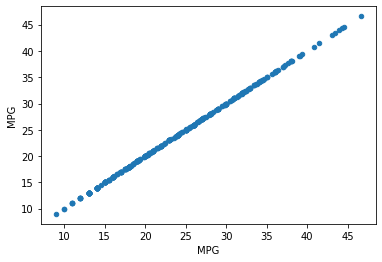

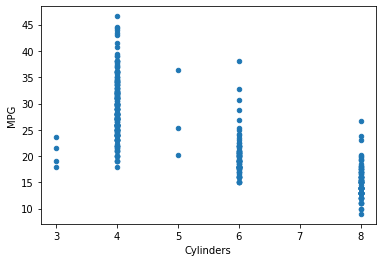

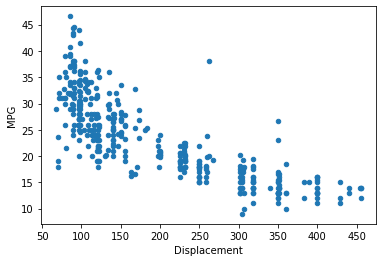

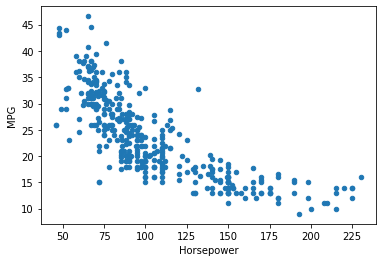

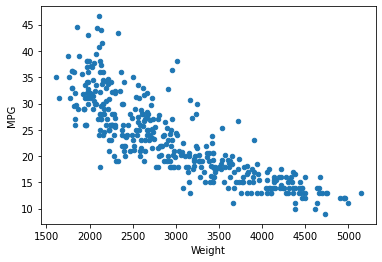

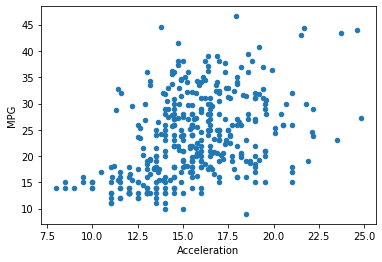

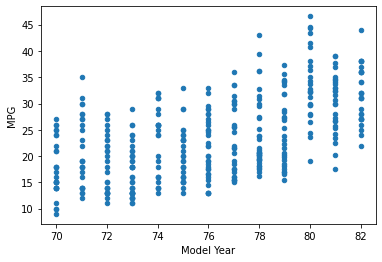

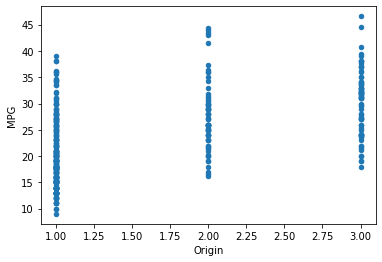

In [ ]:
#グラフの一括表示
for name in non_noo_df.columns:
      non_noo_df.plot(kind = 'scatter', x = name, y = 'MPG')

In [ ]:
#2.4.でnon_dfを使用しているので、正常動作させるために置き換える。
non_df = non_noo_df.copy()

In [ ]:
non_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


##2.4.ダミー変数化

【説明】  
■名義尺度  
他と区別し分類するための名称のようなもの  
例：男女、血液型、郵便番号、住所、本籍地、所属学部、学籍番号  
使える統計量：各ケースの数、計数（count）、頻度（frequency）、最頻値、連関係数  
対処法：get_dummiesを用いてダミー変数化する。その際、変数同士の相関が高いと多重共線性という問題が発生するため、回避するためのオプション（drop_first=True）を使用する。

In [ ]:
#名義尺度の列をダミー変数化
non_noo_df = pd.get_dummies(non_df, drop_first = True, columns = ["Origin"])

#データの内容を確認
non_noo_df

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504,12.0,70,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,0,0
394,44.0,4,97.0,52.0,2130,24.6,82,1,0
395,32.0,4,135.0,84.0,2295,11.6,82,0,0
396,28.0,4,120.0,79.0,2625,18.6,82,0,0


□結果：名義尺度として指定した列がダミー変数化されていること

##2.5.カテゴリ変数化

【説明】  
■順序尺度  
順序や大小には意味があるが間隔には意味がないもの  
例えば、1位＋2位≠3位のように、足し算引き算ができないもの  
例：1位 / 2位 / 3位…、1. 好き / 2. ふつう / 3. 嫌い、統計検定®1級 / 2級 / 3級 / 4級、がんのステージ分類におけるステージI / II / III / IV  
使える統計量：中央値、パーセンタイル  
対処法：LabelEncoderを用いてカテゴリ変数化する。

※今回は不要

##2.6.正解データと特徴量

In [ ]:
#正解データ：1列目(MPG列(燃費))
t = non_noo_df[['MPG']]

#特徴量：2列目以降(MPG列以外)
x = non_noo_df.iloc[:, 1:]

In [ ]:
#正解データの表示
t

,MPG
0,18.0
1,15.0
2,18.0
3,16.0
4,17.0
...,...
393,27.0
394,44.0
395,32.0
396,28.0


In [ ]:
#特徴量の表示
x

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_2,Origin_3
0,8,307.0,130.0,3504,12.0,70,0,0
1,8,350.0,165.0,3693,11.5,70,0,0
2,8,318.0,150.0,3436,11.0,70,0,0
3,8,304.0,150.0,3433,12.0,70,0,0
4,8,302.0,140.0,3449,10.5,70,0,0
...,...,...,...,...,...,...,...,...
393,4,140.0,86.0,2790,15.6,82,0,0
394,4,97.0,52.0,2130,24.6,82,1,0
395,4,135.0,84.0,2295,11.6,82,0,0
396,4,120.0,79.0,2625,18.6,82,0,0


##2.7.標準化

In [ ]:
#StandardScalerをインポート
from sklearn.preprocessing import StandardScaler

In [ ]:
#正解データtの標準化
sc_t = StandardScaler().fit_transform(t)

#標準化したデータの表示
for i in range(5):
    print(sc_t[i])

[-0.69622654]
[-1.08298224]
[-0.69622654]
[-0.95406368]
[-0.82514511]


In [ ]:
#特徴量xの標準化
sc_x = StandardScaler().fit_transform(x)

#標準化したデータの表示
sc_x

array([[ 1.48464698,  1.07771648,  0.66302053, ..., -1.62359292,
        -0.46025863, -0.49678453],
       [ 1.48464698,  1.48938968,  1.57208643, ..., -1.62359292,
        -0.46025863, -0.49678453],
       [ 1.48464698,  1.18302823,  1.18248676, ..., -1.62359292,
        -0.46025863, -0.49678453],
       ...,
       [-0.86541477, -0.56897632, -0.53175181, ...,  1.64459671,
        -0.46025863, -0.49678453],
       [-0.86541477, -0.71258325, -0.66161837, ...,  1.64459671,
        -0.46025863, -0.49678453],
       [-0.86541477, -0.72215704, -0.58369843, ...,  1.64459671,
        -0.46025863, -0.49678453]])

In [ ]:
# #xの標準化モデル
# sc_model_x = StandardScaler()
# sc_model_x.fit(x_train)

# #x_trainの標準化
# sc_x_train = sc_model_x.transform(x_train)

# #標準化したデータの表示
# for i in range(5):
#     print(sc_x_train[i])

In [ ]:
# #yの標準化モデル
# sc_model_y = StandardScaler()
# sc_model_y.fit(y_train)

# #x_trainの標準化
# sc_y_train = sc_model_y.transform(y_train)

# #標準化したデータの表示
# for i in range(5):
#     print(sc_y_train[i])

In [ ]:
# #x_testの標準化
# sc_x_test = sc_model_x.transform(x_test)

# #標準化したデータの表示
# for i in range(5):
#     print(sc_x_test[i])

In [ ]:
# #y_testの標準化
# sc_y_test = sc_model_y.transform(y_test)

# #標準化したデータの表示
# for i in range(5):
#     print(sc_y_test[i])

##2.8.データの分割

In [ ]:
#train_test_splitをインポート
from sklearn.model_selection import train_test_split

#学習データとテストデータに分割
(sc_x_train, sc_x_test, sc_t_train, sc_t_test) = train_test_split(sc_x, sc_t, test_size = 0.2, random_state = 0)

#分割されたデータ数の表示
print(sc_x_train.shape, sc_x_test.shape, sc_t_train.shape, sc_t_test.shape)

(311, 8) (78, 8) (311, 1) (78, 1)


#3.学習

##3.1.線形回帰モデルでの実装

###3.1.1.学習

In [ ]:
#LinearRegressionのインポート
from sklearn.linear_model import LinearRegression

# 学習
model = LinearRegression()
model.fit(sc_x_train, sc_t_train)

LinearRegression()

###3.1.2.予測

In [ ]:
#テストデータを渡して予測結果を取得
sc_predict = model.predict(sc_x_test)

#予測結果の出力
for i in range(5):
    print(sc_predict[i])

[0.65087419]
[-0.14314946]
[0.68045032]
[0.05506393]
[-0.34990997]


In [ ]:
#標準化された結果を実数値化する
predict = StandardScaler().fit(t).inverse_transform(sc_predict)

#予測結果の出力
for i in range(5):
    print(predict[i][0])

28.449237548467263
22.290127473021506
28.678654702664716
23.82763597006496
20.686320362352777


In [ ]:
#標準化された結果を実数値化する
t_test = StandardScaler().fit(t).inverse_transform(sc_t_test)

#結果の出力
for i in range(5):
    print(t_test[i][0])

27.0
19.0
27.5
23.0
17.6


In [ ]:
#テストデータを用いた予測結果と正解データの表示
for i in range(len(t_test)):
    print('予測結果：{:.2f}[mpg] \t 正解データ：{:.2f}[mpg]'.format(predict[i][0], t_test[i][0]))

予測結果：28.45[mpg] 	 正解データ：27.00[mpg]
予測結果：22.29[mpg] 	 正解データ：19.00[mpg]
予測結果：28.68[mpg] 	 正解データ：27.50[mpg]
予測結果：23.83[mpg] 	 正解データ：23.00[mpg]
予測結果：20.69[mpg] 	 正解データ：17.60[mpg]
予測結果：31.66[mpg] 	 正解データ：31.50[mpg]
予測結果：25.64[mpg] 	 正解データ：26.80[mpg]
予測結果：20.26[mpg] 	 正解データ：17.00[mpg]
予測結果：20.83[mpg] 	 正解データ：23.00[mpg]
予測結果：18.96[mpg] 	 正解データ：20.00[mpg]
予測結果：29.42[mpg] 	 正解データ：32.00[mpg]
予測結果：11.28[mpg] 	 正解データ：14.00[mpg]
予測結果：16.13[mpg] 	 正解データ：11.00[mpg]
予測結果：25.57[mpg] 	 正解データ：19.80[mpg]
予測結果：22.04[mpg] 	 正解データ：19.90[mpg]
予測結果：23.41[mpg] 	 正解データ：20.00[mpg]
予測結果：10.73[mpg] 	 正解データ：12.00[mpg]
予測結果：25.21[mpg] 	 正解データ：24.00[mpg]
予測結果：23.75[mpg] 	 正解データ：19.40[mpg]
予測結果：28.25[mpg] 	 正解データ：31.00[mpg]
予測結果：34.52[mpg] 	 正解データ：44.60[mpg]
予測結果：29.45[mpg] 	 正解データ：27.20[mpg]
予測結果：24.27[mpg] 	 正解データ：19.10[mpg]
予測結果：24.80[mpg] 	 正解データ：22.00[mpg]
予測結果：27.17[mpg] 	 正解データ：25.00[mpg]
予測結果：18.37[mpg] 	 正解データ：15.00[mpg]
予測結果：22.13[mpg] 	 正解データ：20.60[mpg]
予測結果：20.36[mpg] 	 正解データ：20.00[mpg]
予測結果：27.93[mpg] 	 正解

###3.1.3.精度

In [ ]:
# (1)決定係数の算出
# 手順：2.1. -> 2.2.1. -> 2.3.1 -> 2.4. ->2.6. ->2.7. -> 2.8. ->3.1. 
model.score(sc_x_test, sc_t_test)

0.8387519287083124

In [ ]:
# (2)決定係数の算出
# 手順：2.1. -> 2.2.2. -> 2.3.1 -> 2.4. ->2.6. ->2.7. -> 2.8. ->3.1. 
model.score(sc_x_test, sc_t_test)

0.8293121546198535

In [ ]:
# (3)決定係数の算出
# 手順：2.1. -> 2.2.3. -> 2.3.1 -> 2.4. ->2.6. ->2.7. -> 2.8. ->3.1. 
model.score(sc_x_test, sc_t_test)

0.8267779755698317

【考察】
(1),(2),(3)より、欠損値に関しては(1)のように削除すると精度は高くなった。  
穴埋めで上がっていないので、別手法による穴埋めが有効かもしれない。

In [ ]:
# (4)決定係数の算出
# 手順：2.1. -> 2.2.1. -> 2.3.2 -> 2.4. ->2.6. ->2.7. -> 2.8. ->3.1. 
model.score(sc_x_test, sc_t_test)

0.8320179343493099

【考察】(1),(4)より、目視の方が精度は高くなった。  
目視は2件、マハラノビスは3件の削除で、削除対象は各々異なる結果となっている。  
マハラノビスの閾値が広くなる（削除対象が増える）と決定係数は下がる。  
目視での削除対象がマハラノビスで対象となっていない。  
時間切れですが、マハラノビスの使用法の理解を深めたい。

In [ ]:
# (5)決定係数の算出
# 手順：2.1. -> 2.2.1. -> 2.3.2 ->2.6. ->2.7. -> 2.8. ->3.1. 	
model.score(sc_x_test, sc_t_test)

0.8029233780837943

【考察】(1),(5)より、ダミー変数化は(1)のように実施した方が精度が高かった。

##3.2.ラッソ回帰モデルでの実装

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

#2乗列と交互作用項を追加
pf = PolynomialFeatures(degree = 2, include_bias = False)
pf_x = pf.fit_transform(sc_x)

#行数と列数を表示
pf_x.shape

(398, 44)

In [ ]:
#列名を確認
pf.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x1 x6',
 'x1 x7',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x2 x6',
 'x2 x7',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x3 x6',
 'x3 x7',
 'x4^2',
 'x4 x5',
 'x4 x6',
 'x4 x7',
 'x5^2',
 'x5 x6',
 'x5 x7',
 'x6^2',
 'x6 x7',
 'x7^2']

In [ ]:
# ライブラリのインポート
from sklearn.linear_model import Lasso

# 訓練データ、テストデータを再作成
x_train, x_test, y_train, y_test = train_test_split(pf_x, sc_t, test_size = 0.3, random_state = 0)

# ラッソ回帰のモデル作成(alphaは正則化項につく定数)
model = Lasso(alpha = 0.1)

# 訓練データで学習
model.fit(x_train, y_train)

# 訓練データの決定係数を表示
print(model.score(x_train, y_train))

# テストデータの決定係数を表示
print(model.score(x_test, y_test))

0.8260959189786408
0.8055972011209573


In [ ]:
# 係数を抜き出す
weight = model.coef_
# 見やすいようにシリーズ変換
pd.Series(weight, index = pf.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0      -0.000000
x1      -0.000000
x2      -0.075605
x3      -0.573140
x4       0.000000
x5       0.270980
x6       0.000000
x7       0.000000
x0^2    -0.000000
x0 x1    0.000000
x0 x2    0.000000
x0 x3    0.000000
x0 x4   -0.000000
x0 x5   -0.000000
x0 x6   -0.000000
x0 x7   -0.000000
x1^2     0.000000
x1 x2    0.000000
x1 x3    0.000000
x1 x4   -0.000000
x1 x5   -0.000000
x1 x6   -0.000000
x1 x7   -0.000000
x2^2     0.000000
x2 x3    0.000000
x2 x4   -0.000000
x2 x5   -0.000000
x2 x6   -0.000000
x2 x7   -0.000000
x3^2     0.019701
x3 x4   -0.000000
x3 x5   -0.019534
x3 x6   -0.000000
x3 x7   -0.000000
x4^2     0.022364
x4 x5    0.000000
x4 x6    0.044442
x4 x7    0.000000
x5^2     0.000000
x5 x6    0.000000
x5 x7    0.000000
x6^2     0.000786
x6 x7   -0.000000
x7^2     0.033798
dtype: float64

#4.モデルの保存

In [ ]:
#pickleをインポート
import pickle

#モデルを保存
with open('auto_mpg.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
ls -l | grep auto_mpg.csv

-rw-r--r-- 1 root root 12795 Mar 15 19:10 auto_mpg.csv


□結果：「auto_mpg.pkl」が存在すること

#5.備考

分類を先に実施し、その形式に合わせようとしたのが不味かったです。  
線形回帰とラッソで処理手順が異なるので、一つのファイルにすると煩雑になりチューニングに時間を割けずじまいでした。